In [61]:
import numpy as np
import pandas as pd
import os.path as path
from typing import Dict, List, Generator, Union, Optional
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, Iterator
from PIL import Image
import albumentations as A
from os import mkdir, listdir, walk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from collections.abc import Iterable
import gc
from sklearn.model_selection import cross_validate
import progressbar

ModuleNotFoundError: No module named 'progressbar'

## Data Extraction

In [23]:
data_path: str = path.normpath("./data/raw")
data_csv_path: str = "butterflies_and_moths.csv"

In [24]:
dir_path: str = path.dirname(path.abspath("."))

In [25]:
data: pd.DataFrame = pd.read_csv(path.join(dir_path, data_path, data_csv_path))

## Data analysis

In [26]:
def show_class_data_diff(data: pd.DataFrame, class_id_name: str, data_set_name: str) -> None:
    """ Функция показывает балансировку данных по классам
    param: data: датафрейм где нужно посмотреть балансировку
           class_id_name колонка в которой находятся классы (по сути не нужны, можно было руками прописать)
           data_set_name колонка в которой хранится тип данных (train, test, validate) (по сути не нужны, можно было руками прописать)
    return: None
    """
    data_gu: pd.DataFrame = data.groupby([class_id_name, data_set_name]).nunique()
    unique_data_set: np.ndarray = data[data_set_name].unique()
    class_balanse: Dict[str, List[int]] = {}
    for name in unique_data_set:
        class_balanse[name] = []
    for ind, vals in enumerate(data_gu.values):
    # data_gu.iloc[[ind]].index[0] получает смердженный индекс например "(0, 'test')"
    # vals[0] это количество уникальных картинок
        class_balanse[data_gu.iloc[[ind]].index[0][1]].append(vals[0])
    for ind, name in enumerate(unique_data_set):
        plt.figure(figsize=(6,6))
        plt.subplot(3, 1, ind + 1)
        plt.plot(class_balanse[name])
        plt.title(f"Балансировка класса у {name}")
    plt.show()

In [27]:
# data_gu = data.groupby(["class id", "data set"]).nunique()

In [28]:
# unique_data_set: np.ndarray = data['data set'].unique()
# class_balanse: Dict[str, List[int]] = {}
# for name in unique_data_set:
#     class_balanse[name] = []

In [29]:
# data_gu

In [30]:
# for ind, vals in enumerate(data_gu.values):
#     # data_gu.iloc[[ind]].index[0] получает смердженный индекс например "(0, 'test')"
#     # vals[0] это количество уникальных картинок
#     class_balanse[data_gu.iloc[[ind]].index[0][1]].append(vals[0])

In [31]:
# for ind, name in enumerate(unique_data_set):
#     plt.figure(figsize=(6,6))
#     plt.subplot(3, 1, ind + 1)
#     plt.plot(class_balanse[name])
#     plt.title(f"Балансировка класса у {name}")
# plt.show()

In [32]:
data['class id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

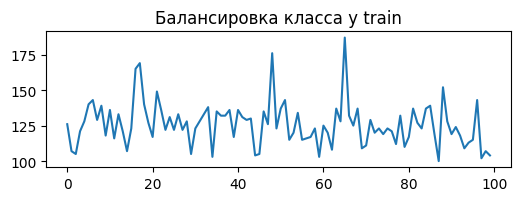

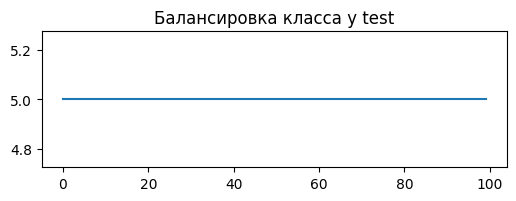

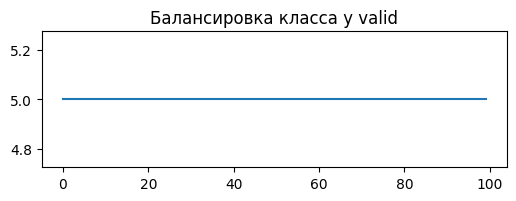

In [33]:
show_class_data_diff(data, "class id", "data set")

## Data preparation

### Data Augumentation

In [34]:
height = 224
width = 224

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.8, p=0.1),
    A.RandomResizedCrop(height=height, width=width, p=0.1),
    A.RandomRotate90(p=0.1),
    A.RandomToneCurve(scale=0.3, p=0.1),
    A.ElasticTransform(alpha=2.28, p=0.1),
    A.GaussNoise(mean=6, p=0.1),
    A.AdvancedBlur(p=0.1),
    A.RandomRain(brightness_coefficient=0.8, blur_value= 5, p=0.1),
], p=1)


limit_of_class_images = 10

In [35]:
def create_augument_dataset(
        data: pd.DataFrame, input_dir: str,
        output_dir: str, data_set_type: str = "train",
        data_set_name:str = "data set", class_id_name: str = "class id", do_aug: Union[bool, int] = True ) -> None:
    """ Функция создает аугументированные данные и сохраняет старые, создает увеличенный датасет
    param: data: данные у которых хотим создать аугументацию
           input dir: место где хранятня папки train/valid/test
           output dir: место куда хотите сохранить новые данные
           data_set_name: название колонки, в которых хранится тип данных (по сути не нужны, можно было руками прописать)
           class_id_name: название колонки, в которой находятся классы (по сути не нужны, можно было руками прописать)
    return: None 
    """
    tmp_data: pd.DataFrame = data[data[data_set_name] == data_set_type]
    for class_id in range(len(tmp_data[class_id_name].unique())):
        counter: int = 0
        class_data: pd.DataFrame = tmp_data[tmp_data[class_id_name] == class_id]
        rows: int = len(class_data)
        #need rows для балансировки классов
        need_rows: int = limit_of_class_images - rows
        if path.exists(data_set_type):
            # raise Exception(f"Уже существует папка {data_set_type}")
            pass
        else:
            mkdir(data_set_type)
        for row in class_data.values:
            if path.exists(path.join(data_set_type, row[2])):
                # raise Exception(f"существует уже такая папка {path.join(data_set_type, row[2])}")
                pass
            else:
                mkdir(path.join(data_set_type, row[2]))
            img_path: str = path.join(input_dir, data_set_type, path.normpath(row[1]).split("\\", 1)[1])
            img_o: Image = Image.open(img_path)
            if counter < need_rows and do_aug:
                img: np.ndarray = np.array(img_o)
                transformed: A.Compose = transform(image=img)['image']
                Image.fromarray(transformed).save(path.join(output_dir, data_set_type, row[2], f"aug{counter}.jpg"))
            img_o.save(path.join(output_dir, data_set_type, row[2], f"{counter}.jpg"))
            counter += 1
            img_o.close()

In [36]:
# create_augument_dataset(data, "D:\work\тад\TAD3lab\mainpy\\tadlab3\data\\raw", "D:\work\тад\TAD3lab\mainpy\\tadlab3\\notebooks", data_set_type="test", do_aug=False)

In [43]:
def create_csv_data(
        data: pd.DataFrame, input_dir: str, output_dir: str) -> str: #data_set_type: str = "train", data_set_name:str = "data set", class_id_name: str = "class id") -> List[Generator]:
    new_data: pd.DataFrame = data.iloc[:0].copy()  
    new_data["img"] = 0
    """Функция создания датасета на основе данных
    param: data: датасет с которого копировать стилистику
           input_dir папка с данными
           output_dir куда сохранить данные
    return: путь по которому сохранил данные
    """
    for data_set_type in listdir(path.normpath(input_dir)):
        path_to_type: str = path.join(input_dir, data_set_type)
        if path.isdir(path_to_type):
            for class_id_type in listdir(path_to_type):
                path_to_class: str = path.join(path_to_type, class_id_type)
                if path.isdir(path_to_class):
                    for file in listdir(path_to_class):
                        path_to_file: str = path.join(path_to_class, file) 
                        with Image.open(path_to_file) as file:
                            img = file.resize((80, 80))
                            img = np.array(img)               
                            new_data.loc[len(new_data)] = [
                                data[data['labels'] == class_id_type].iloc[0].values[0],
                                path_to_file, class_id_type, data_set_type, np.ravel(img)
                                ]
    # path_to_save: str = path.join(path.normpath(output_dir), "data.csv")     
    # if path.exists(path_to_save):
    #     raise Exception("Файл уже существует")
    # else:
    #     new_data.to_csv(path_to_save, index=False)
    return new_data
    

In [44]:
augumented_data = create_csv_data(data, "D:\work\тад\TAD3lab\mainpy\\tadlab3\\notebooks", "D:\work\тад\TAD3lab\mainpy\\tadlab3\\notebooks")

In [45]:
augumented_data = augumented_data.sample(frac=1)

In [47]:
augumented_data

,class id,filepaths,labels,data set,img
21476,97,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\v...,WOOD SATYR,valid,"[75, 78, 15, 77, 79, 16, 80, 81, 19, 83, 81, 2..."
20528,2,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\v...,AMERICAN SNOOT,valid,"[111, 164, 54, 125, 164, 65, 157, 180, 94, 171..."
2263,8,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\t...,BANDED ORANGE HELICONIAN,train,"[66, 140, 41, 64, 138, 39, 64, 138, 39, 64, 13..."
541,0,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\t...,ADONIS,train,"[7, 13, 9, 6, 13, 7, 5, 13, 5, 7, 15, 4, 9, 17..."
4956,22,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\t...,CHECQUERED SKIPPER,train,"[116, 189, 81, 119, 189, 82, 121, 186, 82, 128..."
...,...,...,...,...,...
12228,58,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\t...,MADAGASCAN SUNSET MOTH,train,"[255, 255, 251, 255, 255, 252, 255, 255, 254, ..."
7815,36,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\t...,EASTERN COMA,train,"[16, 13, 6, 17, 14, 6, 52, 48, 37, 75, 69, 55,..."
3348,14,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\t...,BLUE MORPHO,train,"[136, 107, 46, 140, 111, 49, 138, 108, 46, 127..."
20127,98,D:\work\тад\TAD3lab\mainpy\tadlab3\notebooks\t...,YELLOW SWALLOW TAIL,train,"[96, 108, 85, 92, 97, 79, 112, 104, 110, 144, ..."


In [48]:

x_train = augumented_data['img'].values / 255
y_train = augumented_data['class id'].values



In [76]:
model = HistGradientBoostingClassifier(verbose=1)
cross_model = cross_validate(model, list(x_train)[0:20], list(y_train)[0:20], cv=2, scoring=("accuracy", "recall", "precision"), return_estimator=True, return_train_score=True, verbose=1)

Binning 0.002 GB of training data: 

d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


0.617 s
Fitting gradient boosted rounds:
[1/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[2/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[3/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[4/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[5/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[6/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[7/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[8/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[9/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[10/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[11/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[12/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.005s
[13/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[14/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[15/100] 10 trees, 10 leaves (1 on avg), max

d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\metrics\_classification.py", line 2299, in recall_score
    _, r, _, _ = p

0.445 s
Fitting gradient boosted rounds:
[1/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[2/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[3/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[4/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[5/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[6/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[7/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[8/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.005s
[9/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[10/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[11/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.004s
[12/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[13/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[14/100] 10 trees, 10 leaves (1 on avg), max depth = 0, in 0.003s
[15/100] 10 trees, 10 leaves (1 on avg), max

d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\programs\anaconda\envs\tadlab3\Lib\site-packages\sklearn\metrics\_classification.py", line 2299, in recall_score
    _, r, _, _ = p

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
cross_model['estimator'][0].predict(list(x_train[30:40]))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [86]:
accuracy = accuracy_score(cross_model['estimator'][0].predict(list(x_train[30:40])), list(y_train[30:40]))
recall = recall_score(cross_model['estimator'][0].predict(list(x_train[30:40])), list(y_train[30:40]))

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [52]:
model.score(list(x_train)[0:10], list(y_train)[0:10])

0.7

In [50]:
# import pickle
# pickle.dump(model, open("HistGradientv1", 'wb'))

In [ ]:
model.sav

[6 'train/ATALA/100.jpg' 'ATALA' 'train']
[26 'train/CLEOPATRA/130.jpg' 'CLEOPATRA' 'train']
[5 'train/ARCIGERA FLOWER MOTH/134.jpg' 'ARCIGERA FLOWER MOTH' 'train']
[94 'train/ULYSES/111.jpg' 'ULYSES' 'train']
[23 'train/CHESTNUT/054.jpg' 'CHESTNUT' 'train']


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\work\\тад\\TAD3lab\\mainpy\\tadlab3\\notebooks\\train\\CHESTNUT\\054.jpg'

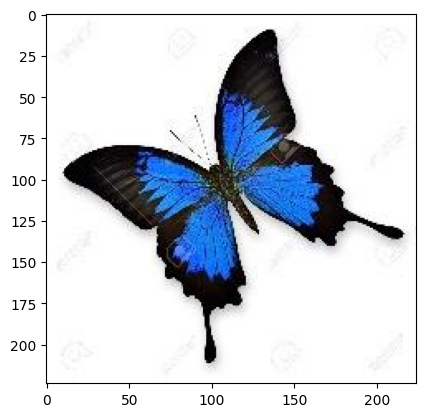

In [ ]:
# gen_data = generate_data(data, "D:\work\тад\TAD3lab\mainpy\\tadlab3\\notebooks")

In [ ]:
# for class_id in range(len(data_train['class id'].unique())):
#     counter = 0
#     class_data = data_train[data_train['class id'] == class_id]
#     rows = len(class_data)
#     need_rows = limit_of_class_images - rows
#     if path.exists('train'):
#         print("Уже существует")
#     else:
#         mkdir("train")
#     for row in class_data.values:
#         if path.exists('train\\' + row[2]):
#             print("есть такой лкасс")
#         else:
#             mkdir('train\\' + row[2])
#         print(row)
#         img_path = path.join(dir_path, data_path, path.normpath(row[1]))
#         img_o = Image.open(img_path)
#         if counter < need_rows:
#             img = np.array(img_o)
#             transformed = transform(image=img)['image']
#             Image.fromarray(transformed).save("train\\" + row[2]+ "\\" + f"aug{counter}.jpg")
#         img_o.save("train\\" + row[2]+ "\\" + f"{counter}.jpg")
#         counter += 1
#         img_o.close()
#     break

Уже существует
есть такой лкасс
[0 'train/ADONIS/001.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/002.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/003.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/004.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/005.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/006.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/007.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/008.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/009.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/010.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/011.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/012.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/013.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/014.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/015.jpg' 'ADONIS' 'train']
есть такой лкасс
[0 'train/ADONIS/016.jpg' 'ADONIS' 'train']
есть тако